In [1]:
import os
import numpy as np
import pandas as pd
import joblib, os, pickle, hashlib, torch, time
import pefile
import ember
import torch
from torch import nn
from torch.nn import functional as F
# from torch.nn.functional import sigmoid
# from features import PEFeatureExtractor


/home/kenchan/anaconda3/envs/ember/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Testset Inference

In [2]:

class MalConvBase(nn.Module):
    def __init__(self, embed_dim, _, out_channels, window_size, dropout=0.5):
        super(MalConvBase, self).__init__()
        self.embed = nn.Embedding(257, embed_dim)
        self.dropout = nn.Dropout(dropout)
        self.conv = nn.Conv1d(
            in_channels=embed_dim,
            out_channels=out_channels * 2,
            kernel_size=window_size,
            stride=window_size,
        )
        self.fc = nn.Linear(out_channels, 1)

    def forward(self, x):
        embedding = self.dropout(self.embed(x))
        conv_in = embedding.permute(0, 2, 1)
        conv_out = self.conv(conv_in)
        glu_out = F.glu(conv_out, dim=1)
        values, _ = glu_out.max(dim=-1)
        output = self.fc(values).squeeze(1)
        return output


class MalConvPlus(nn.Module):
    def __init__(self, embed_dim, max_len, out_channels, window_size, dropout=0.5):
        super(MalConvPlus, self).__init__()
        self.tok_embed = nn.Embedding(257, embed_dim)
        self.pos_embed = nn.Embedding(max_len, embed_dim)
        self.dropout = nn.Dropout(dropout)
        self.conv = nn.Conv1d(
            in_channels=embed_dim,
            out_channels=out_channels * 2,
            kernel_size=window_size,
            stride=window_size,
        )
        self.fc = nn.Linear(out_channels, 1)

    def forward(self, x):
        batch_size, seq_len = x.size(0), x.size(1)
        tok_embedding = self.tok_embed(x)
        pos = torch.arange(seq_len).unsqueeze(0).repeat(batch_size, 1).to(x.device)
        pos_embedding = self.pos_embed(pos)
        embedding = self.dropout(tok_embedding + pos_embedding)
        conv_in = embedding.permute(0, 2, 1)
        conv_out = self.conv(conv_in)
        glu_out = F.glu(conv_out, dim=1)
        values, _ = glu_out.max(dim=-1)
        output = self.fc(values).squeeze(1)
        return output


class RCNN(nn.Module):
    def __init__(
        self,
        embed_dim,
        out_channels,
        window_size,
        module,
        hidden_size,
        num_layers,
        bidirectional,
        residual,
        dropout=0.5,
    ):
        super(RCNN, self).__init__()
        assert module.__name__ in {
            "RNN",
            "GRU",
            "LSTM",
        }, "`module` must be a `torch.nn` recurrent layer"
        self.residual = residual
        self.embed = nn.Embedding(257, embed_dim)
        self.conv = nn.Conv1d(
            in_channels=embed_dim,
            out_channels=out_channels,
            kernel_size=window_size,
            stride=window_size,
        )
        self.rnn = module(
            input_size=out_channels,
            hidden_size=hidden_size,
            num_layers=num_layers,
            bidirectional=bidirectional,
        )
        self.dropout = nn.Dropout(dropout)
        rnn_out_size = (int(bidirectional) + 1) * hidden_size
        if residual:
            self.fc = nn.Linear(out_channels + rnn_out_size, 1)
        else:
            self.fc = nn.Linear(rnn_out_size, 1)

    def forward(self, x):
        embedding = self.dropout(self.embed(x))
        conv_in = embedding.permute(0, 2, 1)
        conv_out = self.conv(conv_in)
        if self.residual:
            values, _ = conv_out.max(dim=-1)
        conv_out = conv_out.permute(2, 0, 1)
        rnn_out, _ = self.rnn(conv_out)
        fc_in = rnn_out[-1]
        if self.residual:
            fc_in = torch.cat((fc_in, values), dim=-1)
        output = self.fc(fc_in).squeeze(1)
        return output


class AttentionRCNN(nn.Module):
    def __init__(
        self,
        embed_dim,
        out_channels,
        window_size,
        module,
        hidden_size,
        num_layers,
        bidirectional,
        attn_size,
        residual,
        dropout=0.5,
    ):
        super(AttentionRCNN, self).__init__()
        assert module.__name__ in {
            "RNN",
            "GRU",
            "LSTM",
        }, "`module` must be a `torch.nn` recurrent layer"
        self.residual = residual
        self.embed = nn.Embedding(257, embed_dim)
        self.conv = nn.Conv1d(
            in_channels=embed_dim,
            out_channels=out_channels,
            kernel_size=window_size,
            stride=window_size,
        )
        self.rnn = module(
            input_size=out_channels,
            hidden_size=hidden_size,
            num_layers=num_layers,
            bidirectional=bidirectional,
        )
        rnn_out_size = (int(bidirectional) + 1) * hidden_size
        self.local2attn = nn.Linear(rnn_out_size, attn_size)
        self.global2attn = nn.Linear(rnn_out_size, attn_size, bias=False)
        self.attn_scale = nn.Parameter(
            nn.init.kaiming_uniform_(torch.empty(attn_size, 1))
        )
        self.dropout = nn.Dropout(dropout)
        if residual:
            self.fc = nn.Linear(out_channels + rnn_out_size, 1)
        else:
            self.fc = nn.Linear(rnn_out_size, 1)

    def forward(self, x):
        embedding = self.dropout(self.embed(x))
        conv_in = embedding.permute(0, 2, 1)
        conv_out = self.conv(conv_in)
        if self.residual:
            values, _ = conv_out.max(dim=-1)
        conv_out = conv_out.permute(2, 0, 1)
        rnn_out, _ = self.rnn(conv_out)
        global_rnn_out = rnn_out.mean(dim=0)
        attention = torch.tanh(
            self.local2attn(rnn_out) + self.global2attn(global_rnn_out)
        ).permute(1, 0, 2)
        alpha = F.softmax(attention.matmul(self.attn_scale), dim=-1)
        rnn_out = rnn_out.permute(1, 0, 2)
        fc_in = (alpha * rnn_out).sum(dim=1)
        if self.residual:
            fc_in = torch.cat((fc_in, values), dim=-1)
        output = self.fc(fc_in).squeeze(1)
        return output

In [3]:
def extract_features(data):
    extractor = ember.PEFeatureExtractor(2)
    # temp = extractor.feature_vector(data)
    # print(temp)
    features = np.array(extractor.feature_vector(data), dtype=np.float32)
    pe = pefile.PE(data=data)
    return [features], list(pe.header)


In [5]:
result = []
test = r"../test/datasets/gw2/0000"
with open(test, "rb") as f:
    data = f.read()
features_data, header = extract_features(data)

## RF 1

In [6]:
clf = joblib.load("../models/rf_ember_subset.joblib")
# features = pickle.load(open("../models/features.pkl", "rb"))
clf.predict_proba(features_data)
# pe_features = np.array([features_data[feature] for feature in features])
# y_pred = clf.predict_proba([pe_features])
# predictions.append(int(prediction1[0]))

array([[0.28810592, 0.71189408]])

## Malconv

In [7]:
# Load Malconv Model
embed_dim = 8
max_len = 4096
out_channels = 128
window_size = 32
dropout = 0.5
weight_path = "../models/malconv_v2.pt"
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
model = MalConvPlus(embed_dim, max_len, out_channels, window_size, dropout)
model.load_state_dict(torch.load(weight_path))
model.to(device)
model.eval()
input = torch.tensor(header).unsqueeze(0).to(device)
y_pred2 = torch.sigmoid(model(input))



/home/kenchan/anaconda3/envs/ember/lib/python3.6/site-packages/torch/cuda/__init__.py:80: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


## RNN

In [6]:
selected_features = [2379, 32, 683, 17, 596, 126, 106, 613, 626, 637, 164, 641, 592, 725]
selected = features_data[0][selected_features]
selected

array([ 0.0000000e+00,  3.3434941e-03,  4.0000000e+00,  4.6179793e-03,
        9.4210152e-03,  2.5288749e-03,  2.8279808e-03,  1.5000000e+01,
        1.2600535e+09,  0.0000000e+00,  2.8295266e-03, -1.0000000e+00,
        1.3463892e-02, -1.0240000e+03], dtype=float32)

In [9]:
from torch import nn

class MalwareDetector(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MalwareDetector, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.unsqueeze(1)
        out, _ = self.rnn(x)
        last_output = out[:, -1, :]
        out = self.fc(last_output)
        return out

selected_features = [2379, 32, 683, 17, 596, 126, 106, 613, 626, 637, 164, 641, 592, 725]
input_size = 14
hidden_size = 64
output_size = 2
dl_model = MalwareDetector(input_size, hidden_size, output_size)
dl_path = os.path.join("../models/malware_detector.pth")
dl_model.load_state_dict(torch.load(dl_path))
dl_model.eval()
with open("../models/scaler.pickle", "rb") as f:
    mean, var = pickle.load(f)
std = np.sqrt(var)
with torch.no_grad():
    features_data = (features_data-mean)/std
    selected = [features_data[0][selected_features]]
    features = torch.tensor(selected, dtype=torch.float32)
    output = dl_model(features)
    _, predicted = torch.max(output, 1)
    # predictions.append(predicted.item())

c:\Users\vboxuser\miniconda3\envs\malware\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
c:\Users\vboxuser\miniconda3\envs\malware\lib\site-packages\ipykernel_launcher.py:30: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)


In [10]:
output.tolist()[0]

[-3.501063346862793, 3.095097303390503]

In [26]:
result.append(y_pred.tolist()[0] + y_pred2.tolist() + y_pred3.tolist()[0])

## Inference

In [49]:
from tqdm import tqdm
basePath = "../test/datasets"
all_results = []
# load RF models
clf = joblib.load("../models/rf_ember.joblib")
# bodmas_clf = joblib.load("../models/bodmas/model.joblib")
# features = pickle.load(open("../models/features.pkl", "rb"))
# Load Malconv Model
embed_dim = 8
max_len = 4096
out_channels = 128
window_size = 32
dropout = 0.5
weight_path = "../models/malconv_v2.pt"
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
malconv = MalConvPlus(embed_dim, max_len, out_channels, window_size, dropout)
malconv.load_state_dict(torch.load(weight_path))
malconv.to(device)
malconv.eval()

# selected_features = [2379, 32, 683, 17, 596, 126, 106, 613, 626, 637, 164, 641, 592, 725]
# input_size = 14
# hidden_size = 64
# output_size = 2
# dl_model = MalwareDetector(input_size, hidden_size, output_size)
# dl_path = "../models/malware_detector.pth"
# dl_model.load_state_dict(torch.load(dl_path))
# dl_model.eval()

# with open("../models/scaler.pickle", "rb") as f:
#     mean, var = pickle.load(f)

for folder in os.listdir(basePath):
    if "mw" in folder:
        label = 1
    else:
        label = 0
    results = []
    folderPath = os.path.join(basePath, folder)
    fileCount = 0
    if os.path.isfile(folderPath):
        continue
    for file in tqdm(os.listdir(folderPath)):
        filePath = os.path.join(folderPath, file)
        # print(filePath)
        # break
        with open(filePath, "rb") as f :
            data = f.read()
        try:
            features_data, header = extract_features(data)
        except:
            # results.append([folder+"_"+file] + [folder] + [label] + [1.0, 0.0, 0.0, 1.0, 0.0])
            results.append([folder+"_"+file] + [folder] + [label] + [1.0, 0.0, 0.0])
            continue
        input = torch.tensor(header).unsqueeze(0).to(device)
        y_pred = clf.predict_proba(features_data)
        with torch.no_grad():
            y_pred2 = torch.sigmoid(malconv(input))
            features = torch.tensor(features_data, dtype=torch.float32)
            # features_data = (features_data-mean)/std
            # selected = [features_data[0][selected_features]]
            # print(selected)
            # y_pred3 = dl_model(features)
            # y_pred3 = torch.softmax(y_pred3, dim = -1)
            # _, predicted = torch.max(y_pred3, 1)
        # pe_features = np.array([features_data[feature] for feature in features])
        # y_pred3 = bodmas_clf.predict_proba([pe_features])
        # results.append([folder+"_"+file] + [folder] + [label] +y_pred.tolist()[0] + y_pred2.tolist() + y_pred3.tolist()[0])
        results.append([folder+"_"+file] + [folder] + [label] +y_pred.tolist()[0] + y_pred2.tolist() )
        # break
    all_results += results
    # break
# all_results

100%|██████████| 58/58 [00:22<00:00,  2.62it/s]


lief error:  This file is not a PE binary


100%|██████████| 82/82 [00:25<00:00,  3.23it/s]


In [51]:
# df = pd.DataFrame(all_results, columns=["FileName", "Dataset", "Label", "y_pred0_0", "y_pred0_1", "y_pred1", "y_pred2_0", "y_pred2_1"])
df = pd.DataFrame(all_results, columns=["FileName", "Dataset", "Label", "y_pred0_0", "y_pred0_1", "y_pred1"])
# df2 = df
# len(all_results)

In [14]:
df.tail()

,FileName,Dataset,Label,y_pred0_0,y_pred0_1,y_pred1
595,gw6_0011,gw6,0,0.958710,0.041290,0.000002
596,gw6_0054,gw6,0,0.739083,0.260917,0.000001
597,gw6_0078,gw6,0,0.868889,0.131111,0.000278
598,gw6_0064,gw6,0,0.845930,0.154070,0.001095
599,gw6_0034,gw6,0,0.958990,0.041010,0.000040


In [16]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x /e_x.sum(axis=1, keepdims=True)
df[['y_pred2_0', 'y_pred2_1']] = softmax(df[['y_pred2_0', 'y_pred2_1']].values)

In [52]:
# df['pred0_label'] = (df['y_pred0_1'] > 0.45).astype(int)
df['pred1_label'] = (df['y_pred1'] > 0.3).astype(int)
# df['pred2_label'] = (df['y_pred2_1'] > 0.45).astype(int)

df['pred0_label'] = df[['y_pred0_0', 'y_pred0_1']].idxmax(axis=1).apply(lambda x: int(x[-1]))
# df['pred2_label'] = df[['y_pred2_0', 'y_pred2_1']].idxmax(axis=1).apply(lambda x: int(x[-1]))
# df['vote'] = (df['pred0_label'] + df['pred1_label'] + df['pred2_label'] >= 2).astype(int)
# df['vote'] = (df['pred0_label'] + df['pred1_label'] + df['pred2_label'] >= 2).astype(int)
df.head()

,FileName,Dataset,Label,y_pred0_0,y_pred0_1,y_pred1,pred1_label,pred0_label
0,mw2_0018,mw2,1,0.208266,0.791734,1.000000,1,1
1,mw2_0029,mw2,1,0.842161,0.157839,0.996347,1,0
2,mw2_0003,mw2,1,0.550857,0.449143,0.999998,1,0
3,mw2_0032,mw2,1,0.467679,0.532321,0.943927,1,1
4,mw2_0001,mw2,1,0.813612,0.186388,0.773990,1,0


In [53]:
df.to_csv("all_reults_v5.csv")

# Expt Section

In [69]:
df = pd.read_csv("all_reults_v4.csv", index_col=0)
df.head()

,FileName,Dataset,Label,y_pred0_0,y_pred0_1,y_pred1,pred1_label,pred0_label
0,mw2_0018,mw2,1,0.014755,0.985245,1.000000,1,1
1,mw2_0029,mw2,1,0.594453,0.405547,0.996347,1,0
2,mw2_0003,mw2,1,0.063864,0.936136,0.999998,1,1
3,mw2_0032,mw2,1,0.048411,0.951589,0.943927,1,1
4,mw2_0001,mw2,1,0.571765,0.428235,0.773990,1,0


In [79]:
filter = df[df['Dataset']=='gw6']
filter[filter["pipeline"]!=filter["Label"]]

,FileName,Dataset,Label,y_pred0_0,y_pred0_1,y_pred1,pred1_label,pred0_label,pipeline,correct_pred0,correct_pred1
559,gw6_0065,gw6,0,0.901394,0.098606,0.773733,1,0,1,1,0
564,gw6_0009,gw6,0,0.881575,0.118425,0.498308,0,0,1,1,1
585,gw6_0008,gw6,0,0.438837,0.561163,0.978808,1,1,1,0,0
593,gw6_0007,gw6,0,0.805961,0.194039,0.988968,1,0,1,1,0


In [86]:
# def pipeline(malconv, rf_0, rf_1):
    # rf = [rf_0, rf_1]
    # rf_prob = max(rf)
    # rf_label = rf.index(rf_prob)
    # # print(rf_label)
    # if rf_label:
    #     return 1
    # elif malconv > 0.3:
    #     return 1
    # else:
    #     return 0
    # if (rf_prob > 0.4 and rf_prob < 0.5):
    #     return malconv 
    # else:
    #     return rf_label
    # print(rf_prob)
def pipeline(malconv, rf_0, rf_1):
    if rf_0 > 0.43:
        return 0
        # return rf_label
    elif malconv > 0.3 :
        return 1
    else:
        return 1


df['pipeline'] = df.apply(lambda x: pipeline(x['y_pred1'], x['y_pred0_0'], x['y_pred0_1']), axis=1)
# df['pipeline'] = df.apply(lambda x: pipeline(x['y_pred1'], x['y_pred0_1']), axis=1)
df.head()

,FileName,Dataset,Label,y_pred0_0,y_pred0_1,y_pred1,pred1_label,pred0_label,pipeline,correct_pred0,correct_pred1
0,mw2_0018,mw2,1,0.014755,0.985245,1.000000,1,1,1,1,1
1,mw2_0029,mw2,1,0.594453,0.405547,0.996347,1,0,0,0,1
2,mw2_0003,mw2,1,0.063864,0.936136,0.999998,1,1,1,1,1
3,mw2_0032,mw2,1,0.048411,0.951589,0.943927,1,1,1,1,1
4,mw2_0001,mw2,1,0.571765,0.428235,0.773990,1,0,0,0,1


In [87]:
def calculate_accuracy(group):
    acc_pred0 = (group['pred0_label'] == group['Label']).mean()
    acc_pred1 = (group['pred1_label'] == group['Label']).mean()
    # acc_pred2 = (group['pred2_label'] == group['Label']).mean()
    acc_vote = (group['pipeline'] == group['Label']).mean()
    # vote = (group['pred0_label'] + group['pred1_label'] + group['pred2_label'] >= 2).astype(int).mean()
    # return pd.Series({'Accuracy_pred0': acc_pred0, 'Accuracy_pred1': acc_pred1, 'Accuracy_pred2': acc_pred2, "Pipeline":acc_vote})
    return pd.Series({'Accuracy_pred0': acc_pred0, 'Accuracy_pred1': acc_pred1, "Pipeline":acc_vote})

# Group by 'Dataset' and apply the accuracy function
accuracy_results = df.groupby('Dataset').apply(calculate_accuracy)
accuracy_results

,Accuracy_pred0,Accuracy_pred1,Pipeline
Dataset,,,
gw2,0.588235,0.529412,0.647059
gw3,0.741379,0.603448,0.879310
gw4,0.734694,0.591837,0.755102
gw5,0.780822,0.287671,0.849315
gw6,0.987805,0.963415,1.000000
mw1,0.416667,0.750000,0.416667
mw2,0.880000,0.860000,0.880000
mw3,0.700000,0.700000,0.616667
mw4,0.862069,0.724138,0.862069


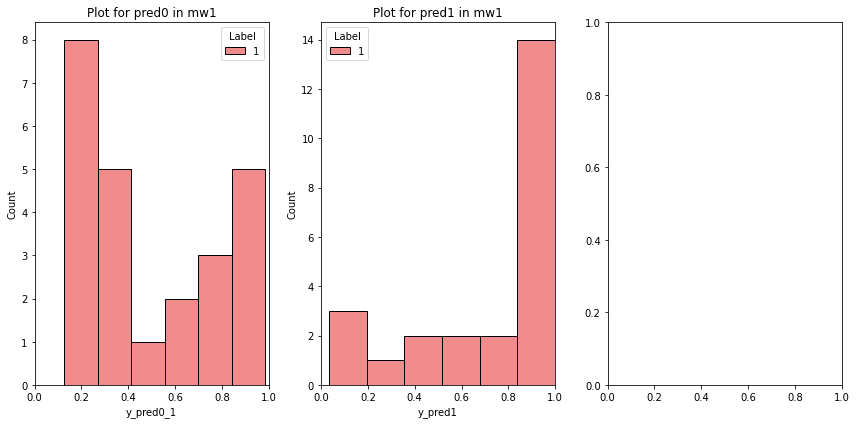

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns
df_viz = df
# Adding new columns for predicted labels
df_viz['pred0_label'] = df_viz[['y_pred0_0', 'y_pred0_1']].idxmax(axis=1).apply(lambda x: int(x[-1]))
df_viz['pred1_label'] = (df_viz['y_pred1'] > 0.5).astype(int)
# df_viz['pred2_label'] = df_viz[['y_pred2_0', 'y_pred2_1']].idxmax(axis=1).apply(lambda x: int(x[-1]))


# Adding columns for correctness
df_viz['correct_pred0'] = (df_viz['pred0_label'] == df_viz['Label']).astype(int)
df_viz['correct_pred1'] = (df_viz['pred1_label'] == df_viz['Label']).astype(int)
# df_viz['correct_pred2'] = (df_viz['pred2_label'] == df_viz['Label']).astype(int)

# datasets = df_viz['Dataset'].unique()
datasets = ["mw1"]
for dataset in datasets:
    plt.figure(figsize=(12, 6))
        
        # Data filtered by current dataset
        
    data_subset = df_viz[df_viz['Dataset'] == dataset]
    # data_subset = df
    # dataset = ""
    # Plot for pred0
    plt.subplot(1, 3, 1)
    # sns.scatterplot(data=data_subset, x='y_pred0_0', y='y_pred0_1', hue='correct_pred0', style='Dataset',
    #                 palette='Set1', markers=True, legend='full')
    # col_name = 'y_pred0_0' if "gw" in dataset else 'y_pred0_1'
    sns.histplot(data=data_subset, x='y_pred0_1', hue='Label', palette='Set1', fill=True)
    plt.title(f'Plot for pred0 in {dataset}')
    # plt.xlabel('Benign Probability')
    # plt.ylabel('Malware Probability')
    plt.xlim(0, 1)  # Set the x-axis limits from 0 to 1
    # plt.ylim(0, 1)  # Set the y-axis limits from 0 to 1

    plt.subplot(1, 3, 2)
    # sns.scatterplot(data=data_subset, x='y_pred0_0', y='y_pred0_1', hue='correct_pred0', style='Dataset',
    #                 palette='Set1', markers=True, legend='full')
    # col_name = 'y_pred1_0' if "gw" in dataset else 'y_pred0_1'
    # plt.xlabel('Benign Probability')
    # plt.ylabel('Malware Probability')
    sns.histplot(data=data_subset, x='y_pred1', hue='Label', palette='Set1', fill=True)
    plt.title(f'Plot for pred1 in {dataset}')
    plt.xlim(0, 1)  # Set the x-axis limits from 0 to 1
    # plt.ylim(0, 1)  # Set the y-axis limits from 0 to 1

    # # Plot for pred2
    plt.subplot(1, 3, 3)
    # # col_name = 'y_pred2_0' if "gw" in dataset else 'y_pred2_1'
    # # sns.scatterplot(data=data_subset, x='y_pred2_0', y='y_pred2_1', hue='correct_pred2', style='Dataset',
    #                 # palette='Set1', markers=True, legend='full')
    # # plt.xlabel('Benign Probability')
    # # plt.ylabel('Malware Probability')
    # sns.histplot(data=data_subset, x='y_pred2_1', hue='Label', palette='Set1', fill=True)
    # plt.title(f'Plot for pred2 in {dataset}')
    # plt.xlim(0, 1)  # Set the x-axis limits from 0 to 1
    # plt.ylim(0, 1)  # Set the y-axis limits from 0 to 1
    # Show plot|
plt.tight_layout()
plt.show()